# Graph Data Science for Supply Chain: Part III
## Path Finding, Optimization, and Recommendation for Supply Chain and Logistics

This notebook demonstrates how [Neo4j Graph Data Science](https://neo4j.com/docs/graph-data-science/current/algorithms/) can be applied to supply chain data to:

- find new, faster, paths through supply chain processes with potential to __improve performance by up to 40%__,
- __facilitate enhanced downstream optimization__ for freight forwarding and supply chain problems in general, and
- conduct __what-if simulations__ to quickly identify alternative routes under delay/failure scenarios and enable deeper risk assessment around critical and high centrality supply chain stages

We will start with a brief recap of the dataset we have been using in the series and overview of shipment routes.  After that, we will explore path finding to show how we can identify new and faster shipment routes, walking through a specific example that reveals potential to improve performance by up to 40%.  We will then show how path finding algorithms can be used to facilitate downstream optimization problems enabling a freight forwarding recommender that returns results in a matter of just a few seconds. Lastly, we explore how these path finding algorithms can further be used in what-if scenario simulations to better understand alternative routing and conduct risk assessment.
It is worth noting that while we are using an air cargo freight forwarding dataset in this post, these same techniques can be applied to other types of logistics, including maritime and trucking services, as well as other types of supply chain domains, including manufacturing, inventory management, and bill of materials.


### Prerequisites
- Neo4j >= 4.3
- GDS >= 2.0
- The Cargo 2000 case study dataset loaded into a Neo4j database. There is a notebook to generate the Neo4j database [here](https://github.com/neo4j-product-examples/demo-supply-chain-logistics/blob/main/airplane-cargo/part1/transform-and-load.ipynb). You can alternatively load the database from [this dump file](https://github.com/neo4j-product-examples/demo-supply-chain-logistics/blob/main/data/c2k-case-study.dump).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ds_utils
from graphdatascience import GraphDataScience

In [2]:
# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience('neo4j://localhost', auth=('neo4j', 'neo'))

## Dataset

For a sample dataset we will use the “Cargo 2000” transport and logistics case study [[1]](#1). Cargo 2000 (re-branded as Cargo iQ in 2016) is an initiative of the International Air Transport Association (IATA) that aims to deliver a new quality management system for the air cargo industry.logistics-diagram.png

The below figure shows a model of the business processes covered in the IATA case study. It represents the business processes of a freight forwarding company, in which up to three smaller shipments from suppliers are consolidated and then shipped together to customers. The business process is structured into incoming and outgoing transport legs, with the overall objective that freight is delivered to customers in a timely manner.  You can find out more about the business model in the [first blog of this series](https://neo4j.com/developer-blog/supply-chain-neo4j-gds-bloom/) where we explored the dataset in Neo4j Bloom or from the [original data source]( https://s-cube-network.eu/c2k/).

<img src="img/logistics-diagram.png" alt="summary" width="1000"/>

## References
<a id="1">[1]</a> A. Metzger, P. Leitner, D. Ivanovic, E. Schmieders, R. Franklin, M. Carro, S. Dustdar, and K. Pohl, “ Comparing and combining predictive business process monitoring techniques,” IEEE Trans. on Systems Man Cybernetics: Systems, 2015.

## Understanding Historic Shipment Routes
In the last two parts of this series we have primarily worked with a collapsed form of the network using the SENDS_TO relationship.  Since we are concerned with specific shipment paths in this part of the series, we will work with the full data model depicted below.

<img src="img/c2k-schema.png" alt="summary" width="1000"/>


Recall from part 1 that shipments consist of one or multiple incoming legs that merge into a single outgoing leg for delivery.  Each leg, incoming and outgoing, has the potential for multiple connecting flights.  For reference, below is an example of what a single shipment looks like in the graph with three incoming legs originating from Davidburgh, Paulchester, and Moodytown, and outgoing leg going to Davisfort.


<img src="img/paths-of-single-shipments.png" alt="summary" width="1000"/>

With this data model we can pull the total effective minutes for historic shipments paths with Cypher. A path being the set of nodes and relationships that track a single incoming leg end-to-end, going from the source airport EntryPoint all the way to the target airport Destination in a shipment. Below is a table and distribution of total time for paths going from Moodytown to Davisfort, one of the most frequent paths in the logistic network.

In [3]:
# Calculate distribution for a single path
source_airport_id = 815 #'Moodytown'
target_airport_id = 700 #'Davisfort'
moodytown_davisfort_df = gds.run_cypher('''
    //match incoming legIds (leg numbers are > 0)
    MATCH(:EntryPoint {airportId: $sourceAirportId})-[r:RECEPTION]->() WHERE r.legNumber > 0
    WITH r.legId AS incomingLegId, r.shipmentId AS shipmentId
    //filter to only shipmentIds that go to target airport
    MATCH()-[:DELIVERY {shipmentId:shipmentId}]->(:Destination {airportId: $targetAirportId})
    WITH incomingLegId, shipmentId
    //incoming relationships
    MATCH()-[r {legId: incomingLegId}]->()
    WITH incomingLegId, shipmentId, sum(r.effectiveMinutes) AS incomingMinutes
    //outgoing relationships (leg numbers are < 0)
    MATCH()-[r {shipmentId: shipmentId}]->() WHERE r.legNumber < 0
    WITH incomingLegId, r.legId AS outgoingLegId, shipmentId, incomingMinutes, sum(r.effectiveMinutes) AS outgoingMinutes
    //sum all results on return
    RETURN incomingLegId, outgoingLegId, shipmentId, incomingMinutes, outgoingMinutes, (incomingMinutes + outgoingMinutes) AS totalMinutes
    ORDER BY incomingLegId
''', params = {'sourceAirportId': source_airport_id, 'targetAirportId': target_airport_id})

moodytown_davisfort_df['incomingDuration'] = ds_utils.minutes_to_duration(moodytown_davisfort_df.incomingMinutes)
moodytown_davisfort_df['outgoingDuration'] = ds_utils.minutes_to_duration(moodytown_davisfort_df.outgoingMinutes)
moodytown_davisfort_df['totalDuration'] = ds_utils.minutes_to_duration(moodytown_davisfort_df.totalMinutes)
moodytown_davisfort_df['totalDurationDays'] = moodytown_davisfort_df.totalMinutes/1440.0
moodytown_davisfort_df.drop(columns=['incomingMinutes', 'outgoingMinutes', 'totalMinutes'], inplace=True)
moodytown_davisfort_df

,incomingLegId,outgoingLegId,shipmentId,incomingDuration,outgoingDuration,totalDuration,totalDurationDays
0,123,8502,1490,"00 days, 21 hrs, 32 min","02 days, 13 hrs, 38 min","03 days, 11 hrs, 10 min",3.465278
1,1430,8403,1067,"04 days, 07 hrs, 55 min","06 days, 21 hrs, 26 min","11 days, 05 hrs, 21 min",11.222917
2,2601,657,1145,"05 days, 06 hrs, 32 min","03 days, 17 hrs, 19 min","08 days, 23 hrs, 51 min",8.993750
3,2617,14366,605,"00 days, 18 hrs, 37 min","01 days, 12 hrs, 01 min","02 days, 06 hrs, 38 min",2.276389
4,2941,7910,1323,"01 days, 07 hrs, 42 min","01 days, 02 hrs, 52 min","02 days, 10 hrs, 34 min",2.440278
...,...,...,...,...,...,...,...
79,10934,6792,2633,"00 days, 09 hrs, 13 min","04 days, 12 hrs, 34 min","04 days, 21 hrs, 47 min",4.907639
80,10942,7971,1267,"01 days, 19 hrs, 50 min","01 days, 15 hrs, 37 min","03 days, 11 hrs, 27 min",3.477083
81,11019,14532,160,"00 days, 12 hrs, 02 min","02 days, 23 hrs, 45 min","03 days, 11 hrs, 47 min",3.490972
82,11127,6299,3167,"02 days, 10 hrs, 06 min","01 days, 04 hrs, 54 min","03 days, 15 hrs, 00 min",3.625000


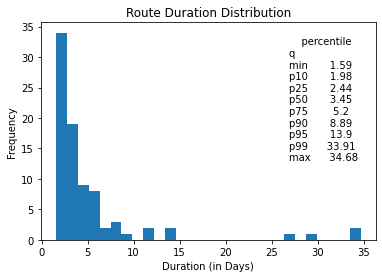

Mean Duration: 5.4 days


In [4]:
def get_percentiles(s, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [round(s.min(),2)] + [round(s.quantile(i), 2) for i in q] + [round(s.max(),2)]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

plt.hist(moodytown_davisfort_df.totalDurationDays, bins=max(round(moodytown_davisfort_df.shape[0]/3),5))
plt.title('Route Duration Distribution')
plt.ylabel('Frequency')
plt.xlabel('Duration (in Days)')
plt.figtext(0.7, 0.4, get_percentiles(moodytown_davisfort_df.totalDurationDays).to_string())
plt.show()
print(f'Mean Duration: {round(moodytown_davisfort_df.totalDurationDays.mean(),1)} days')

Notice the distribution has a long right tail. This is characteristic for many of the other shipment routes where most shipments fall into a tight range of duration times, with a few extreme cases that have much longer times, sometimes ten or more times greater than the median.

## Identify Faster Routes and Improve Performance with Path Finding

GDS has a robust family of [10+ algorithms for path finding](https://neo4j.com/docs/graph-data-science/current/algorithms/pathfinding/).  These algorithms can be used to explore, recommend, and optimize paths in supply chains.  To highlight just a few of these algorithms:

- [Dikstra’s Source-Target Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/dijkstra-source-target/) is a classic graph algorithm for finding the shortest path between two nodes

- [Delta-Stepping Single-Source Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/delta-single-source/) uses parallelized computation to find the shortest paths between a single source node and multiple target nodes.

- [A* Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/astar/) is an extension of Dijkstra that uses heuristics to speed up computation.  Particularly well-suited for paths between geospatial points

In this notebook we will focus on another path finding algorithm called [Yen's K-Shortest Path](https://neo4j.com/docs/graph-data-science/current/algorithms/yens/). Yen’s algorithm is similar to the Dikstra’s Source-Target Shortest Path, but while Djikstra calculates only a single shortest path between a source node and target node, Yens can find multiple, “top k”, shortest paths between a source and target.  This will prove useful later for recommending freight forwarding combinations.

Yen’s algorithm, along with most other GDS Path finding algorithms, can be weighted with relationship properties to take variable costs associated with time, distance, and other operations into consideration.  In this case we will use the average effective minutes of the business processes.  This will allow us to find paths that minimize the approximate average duration, which we will refer to as the “fastest” paths. There are some statistical considerations to keep in mind when using averages this way. Depending on your use case you may also want to choose a different type of aggregate measure. I cover this in more detail in the appendix.  If you are considering using this type of solution in a production capacity I recommend reading it. For now though, the following steps provide a good starting point for path finding based on historical data.

The below Cypher projection aggregates parallel relationships and creates the average effective time relationship property.

In [5]:
g, _ = gds.graph.project.cypher('proj',
    '''
   MATCH(n)
   WHERE n:EntryPoint 
       OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination
   RETURN id(n) as id, labels(n) as labels
   '''
    ,
    '''
    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
    RETURN id(n0) AS source, id(n1) AS target, type(r) AS type, avg(r.effectiveMinutes) AS averageEffectiveMinutes
    '''
)
_

nodeQuery            MATCH(n)\n   WHERE n:EntryPoint \n       OR n:...
relationshipQuery    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DEL...
graphName                                                         proj
nodeCount                                                         1422
relationshipCount                                                 2024
projectMillis                                                       85
Name: 0, dtype: object

After you project the graph you can begin with path finding.  For our first example, let’s get the top 10 shortest paths going from Moodytown to Davisport.

In [6]:
source_airport_name = 'Moodytown'
target_airport_name = 'Davisfort'
source_node_id = gds.find_node_id(['EntryPoint'], {'name': source_airport_name})
target_node_id = gds.find_node_id(['Destination'], {'name': target_airport_name})
yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id, k=10,
                                      relationshipWeightProperty='averageEffectiveMinutes')

In [7]:
def get_airport_names(p):
    return ' -> '.join(list(dict.fromkeys([node.get('name') for node in p.nodes])))
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
yen_df['totalCostFormatted'] = ds_utils.minutes_to_duration(yen_df.totalCost)
top_path_df = yen_df[['airportPath', 'totalCostFormatted']].rename(columns={'totalCostFormatted':'approximateAvgTime'})
top_path_df

,airportPath,approximateAvgTime
0,Moodytown -> Davisfort,"02 days, 14 hrs, 23 min"
1,Moodytown -> Michaelstad -> Davisfort,"03 days, 01 hrs, 29 min"
2,Moodytown -> Wandaborough -> Davisfort,"03 days, 04 hrs, 28 min"
3,Moodytown -> Matthewport -> Davisfort,"03 days, 04 hrs, 57 min"
4,Moodytown -> Bryanside -> Davisfort,"03 days, 06 hrs, 16 min"
5,Moodytown -> Shanefort -> Davisfort,"03 days, 07 hrs, 58 min"
6,Moodytown -> Langborough -> Davisfort,"03 days, 09 hrs, 01 min"
7,Moodytown -> Ramoshaven -> Wandaborough -> Dav...,"03 days, 12 hrs, 24 min"
8,Moodytown -> Wandaborough -> Michaelstad -> Da...,"03 days, 14 hrs, 07 min"
9,Moodytown -> Lisaton -> Michaelstad -> Davisfort,"03 days, 15 hrs, 54 min"


Notice that the best path is a direct flight from Moodytown to Davisport. By nature of the freight forwarding model, we don’t have direct deliveries in the dataset.  We will see later with freight forwarding combinations that there are opportunities for reducing total costs by taking longer routes through connecting airports which motivates the use of multi-step paths despite them taking longer on average. 

Let's compare the above paths to those historically taken in the dataset.  We will do this by merging the above results to actual historic paths which we can pull with Cypher.  Below is the resulting dataframe.

In [8]:
top_path_df.merge(ds_utils.historic_path_counts(gds, source_airport_id, target_airport_id), on='airportPath', 
                  how='outer')

,airportPath,approximateAvgTime,historicPathCount,historicAvgCost,historicCostStd,historicCosts
0,Moodytown -> Davisfort,"02 days, 14 hrs, 23 min",NaN,NaN,NaN,NaN
1,Moodytown -> Michaelstad -> Davisfort,"03 days, 01 hrs, 29 min",48.0,"02 days, 21 hrs, 57 min","01 days, 04 hrs, 49 min","[04days-03hrs-22min, 01days-23hrs-33min, 01day..."
2,Moodytown -> Wandaborough -> Davisfort,"03 days, 04 hrs, 28 min",1.0,"03 days, 11 hrs, 27 min","00 days, 00 hrs, 00 min",[03days-11hrs-27min]
3,Moodytown -> Matthewport -> Davisfort,"03 days, 04 hrs, 57 min",NaN,NaN,NaN,NaN
4,Moodytown -> Bryanside -> Davisfort,"03 days, 06 hrs, 16 min",NaN,NaN,NaN,NaN
5,Moodytown -> Shanefort -> Davisfort,"03 days, 07 hrs, 58 min",5.0,"04 days, 00 hrs, 08 min","01 days, 10 hrs, 17 min","[05days-05hrs-22min, 02days-08hrs-19min, 02day..."
6,Moodytown -> Langborough -> Davisfort,"03 days, 09 hrs, 01 min",1.0,"02 days, 10 hrs, 34 min","00 days, 00 hrs, 00 min",[02days-10hrs-34min]
7,Moodytown -> Ramoshaven -> Wandaborough -> Dav...,"03 days, 12 hrs, 24 min",NaN,NaN,NaN,NaN
8,Moodytown -> Wandaborough -> Michaelstad -> Da...,"03 days, 14 hrs, 07 min",NaN,NaN,NaN,NaN
9,Moodytown -> Lisaton -> Michaelstad -> Davisfort,"03 days, 15 hrs, 54 min",NaN,NaN,NaN,NaN


Notice that the second best path through Michaelstad is by far the most frequently used route historically.  However, there still seem to be many routes that aren’t reflected in our shortest path recommendations.  For example, there are 11 instances going through Scottstown which isn’t even in the top 15 recommended paths, as well as 5 through Amandachester and 4 through Simonfurt.

### Improving Performance by Selecting New Routes
While Scotttown was heavily utilized historically, our application of GDS path finding revealed multiple other faster options. We are already routing many flights through Michaelstad, so what if we routed the Scotttown flights through Wandaborough instead which has a very similar approximate average time to the Michaelstad path?

With a bit of arithmetic, we can estimate that by switching the Scottstown flights to go through Wondaburough instead, __*we could see an approx 40% decrease in average time which is rather significant*__.

To calculate this, it is important to note that the approximate average times from our Yen’s shortest paths and the actual historic average times won’t be exactly the same for a variety of reasons.  These include large variance in flight times and the fact that shortest paths tend to go through flight segment connections rather than proper TransferPoints (points where incoming and outgoing legs connect in the graph schema triggering another freight reception process).  Nevertheless, the shortest path approximate average times and historic average times should be well correlated, and if we assume they are relatively proportional we can estimate differences in performance between different paths. For the above example, we can note that the Wondaburough connected path (#2) is only slightly longer than the Michaelstad connected path (#1) and that the average historic time of the Michaelstad connected path is under 60% that of the Scottstown connected path (#10). A bit of percentage calculations will allow you to reach the solution I came to above.

## Downstream Optimization and Recommendation

Once we can find shortest paths we can use them in downstream optimization and recommendation to aid decision making in supply chains.  In this case we will use them for freight forwarding combinations. Optimization in supply chain networks is a broad and complex topic often involving multiple objectives relating to revenue, time, and expenses as well as constraints around resources, equipment, and other assets.  From a technical standpoint, this can involve linear and nonlinear programming techniques as well as discrete optimization.  Going into depth on these techniques is out of scope for this post.  However, I will walk through a simple example of using shortest paths to optimize and recommend freight forwarding combinations.  This should provide you with enough tooling to get started with using graph data science for your own supply chain optimization problems.

Consider you have 4 shipments going to Sandersshire from the airports
1. Bradleymouth
2. Moodytown
3. Richardberg, and 
4. Wandaborough

We could simply use the shortest path for each route.  Below is the total cost of that solution in minutes as well as a visualization from Bloom.


In [9]:
source_airport_names =  ['Bradleymouth', 'Moodytown', 'Richardberg', 'Wandaborough']
target_airport_name = 'Sandersshire'

shortest_path_list = []
rels = {}
for source_airport_name in source_airport_names:
    source_node_id = gds.find_node_id(['EntryPoint'], {'name': source_airport_name})
    temp_df = gds.shortestPath.dijkstra.stream(g, sourceNode=source_node_id, targetNode=gds.find_node_id(['Destination'], {'name': target_airport_name}),
                                               relationshipWeightProperty='averageEffectiveMinutes')
    for r in temp_df.path[0].relationships:
        rels[f'{r.start_node.id}-{r.end_node.id}'] = r

print(f'Total Average Cost: {round(sum([r.get("cost") for r in rels.values()]), 2)}')

Total Average Cost: 15805.44


In [10]:
ds_utils.write_solution_to_db(gds, rels.values(), 'best-single-paths')

This can be visualized in Bloom using a [search phrase](https://neo4j.com/docs/bloom-user-guide/current/bloom-tutorial/search-phrases-advanced/).  i.e.

- Search phrase: "Solution Path: &#36;s"
- Cypher query: `MATCH (n)-[r:SOLUTION_PATH {solutionTag: $s}]->(m)
RETURN *`

Then you can type "Solution Path: best-single-paths" into the search bar to get the below:


<img src="img/sandersshire-all-shortest-paths.png" alt="summary" width="1000"/>

However, this may not be the best overall solution.  We could, instead choose paths that allow us to better consolidate freight on different legs, allowing us to use less airplanes, less overall resources, and reducing cost.

### Minimal Cost Objective to Recommend Freight Forwarding Combinations

To keep things simple, we will find a freight forwarding solution by minimizing a single objective, total average time.  The total average time is calculated by taking the sum of all the approximate average times in the relationships in the paths. If multiple paths go through the same airport, the business processes (expressed as relationships) for that airport including transport, departure, reception, and delivery will only be counted once. This reflects a cost minimization problem, with a constant variable cost across all business processes. Obviously, for real world application, you may need to vary the cost per business process or develop other rules around how overlapping paths affect total costs, all of which can be accomplished by altering/extending the objective.

Below are the top 10 solutions.  The function `ds_utils.top_k_solutions_from_names` contains all the logic for running Yen's shortest path in GDS and applying the objective function to rank the freight forwarding combinations.

In [11]:
top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, 
                                               target_airport_name).rename(columns={'totalCost':'totalAverageTime'})
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(1, 0, 1, 0)",14069.456562,"[6221.733971695967, 5208.344320769946, 6535.08..."
1,"(1, 1, 1, 0)",14576.614786,"[6221.733971695967, 5715.5025446598775, 6535.0..."
2,"(1, 0, 1, 2)",14640.372950,"[6221.733971695967, 5208.344320769946, 6535.08..."
3,"(1, 4, 1, 0)",14668.587302,"[6221.733971695967, 6011.366365614366, 6535.08..."
4,"(1, 1, 1, 2)",14715.954250,"[6221.733971695967, 5715.5025446598775, 6535.0..."
5,"(1, 0, 1, 3)",14728.186310,"[6221.733971695967, 5208.344320769946, 6535.08..."
6,"(1, 3, 1, 0)",14773.181668,"[6221.733971695967, 5912.069427455579, 6535.08..."
7,"(1, 3, 1, 3)",14775.490364,"[6221.733971695967, 5912.069427455579, 6535.08..."
8,"(1, 0, 0, 0)",14803.355023,"[6221.733971695967, 5208.344320769946, 5629.32..."
9,"(1, 0, 1, 4)",14853.769859,"[6221.733971695967, 5208.344320769946, 6535.08..."


The `solutionIndex` column tells you the rank of the shortest path chosen for each incoming leg in alphabetical order of airport name. For the best solution in the top row, `(1, 0, 1, 0)` reads as using the second fastest path for Bradleymouth, fastest for Moodytown, second fastest for Richardberg, and the fastest for Wandaborough. This top solution results in all four incoming legs getting consolidated in Shanefort for a single outgoing leg.  Below is a visual depiction of the top solution in Bloom.

In [12]:
ds_utils.write_solution_to_db(gds, top_k_df.relationships[0], 'best-overall')

<img src="img/sandersshire-best-yens.png" alt="summary" width="1000"/>

### Adding Constraints

It is possible to add constraints to this form of problem as well.  To demonstrate, let’s put a constraint on max time, such that no single path in the solution can be over m approximate average minutes, thus bounding the time it takes to deliver all the freight. 

I set the max time to 10 hours below and it results in the following top 10 solutions. 

In [13]:
top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, 
    target_airport_name, max_avg_time=6000.0).rename(columns={'totalCost':'totalAverageTime'})
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(0, 0, 0, 0)",15805.435025,"[5584.15472555134, 5208.344320769946, 5629.324..."
1,"(0, 2, 0, 1)",15881.873342,"[5584.15472555134, 5719.924774003627, 5629.324..."
2,"(0, 1, 0, 0)",16312.593249,"[5584.15472555134, 5715.5025446598775, 5629.32..."
3,"(0, 0, 0, 2)",16376.351413,"[5584.15472555134, 5208.344320769946, 5629.324..."
4,"(0, 1, 0, 2)",16451.932714,"[5584.15472555134, 5715.5025446598775, 5629.32..."
5,"(0, 2, 0, 8)",16460.799474,"[5584.15472555134, 5719.924774003627, 5629.324..."
6,"(0, 0, 0, 3)",16464.164773,"[5584.15472555134, 5208.344320769946, 5629.324..."
7,"(0, 3, 0, 0)",16509.160132,"[5584.15472555134, 5912.069427455579, 5629.324..."
8,"(0, 3, 0, 3)",16511.468827,"[5584.15472555134, 5912.069427455579, 5629.324..."
9,"(0, 0, 0, 4)",16589.748322,"[5584.15472555134, 5208.344320769946, 5629.324..."


Note the best solution is now the same as the combination of all best paths, same as is visualized in the all shortest path solution above. While the max time is lower, the freight is not getting consolidated completely in outgoing legs.  

Some of the other top solutions are interesting to consider as well.  For example, the second best solution, visualized in Bloom below, is very close in total average time to the best, but takes a very different approach, routing everything through Davisfort except for Richardberg which is left as a direct path. 

In [14]:
ds_utils.write_solution_to_db(gds, top_k_df.relationships[1], 'second-best-with-constraints')

<img src="img/sandersshire-second-best-yens-constrained.png" alt="summary" width="1000"/>

## What-If Scenarios and Path Finding

You can also use path finding to help simulate what-if scenarios, such as predicting the effect of delays, changes in resources, external shocks, or other new occurrences on the supply chain. This can be applied in a couple different ways:

- __Alternative Routing:__ Find next best options in the event of failures or significant delays
- __Risk Assessment:__ Perform analysis to understand the effect of failures, significant delays, or other issues on supply chain performance.

### Alternative Routing

As an example of alternative routing, let's assume that Shanefort becomes overloaded and, in conjunction with bad weather, is no longer a viable connection/transfer option for freight forwarding.

In this scenario we can scan each solution for a result that doesn't involve Shanefort.

In [15]:
top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names,
                                               target_airport_name, top_k=30).rename(columns={'totalCost':'totalAverageTime'})

def rels_does_not_contain_airport(rels, airport_name):
    for r in rels:
       if r.end_node.get('name') == airport_name:
           return False
    return True

any(top_k_df.relationships.apply(lambda x: rels_does_not_contain_airport(x, 'Shanefort')))

False

However this wont always work. As we see above, all the top paths involved Shanefort. Luckily GDS allows us to quickly re-project a graph, and when we do we can easily exclude Shanefort.

In [16]:
g.drop()
g, _ = gds.graph.project.cypher('proj',
    '''
    MATCH(n)
    WHERE (n:EntryPoint OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination)
        AND  (n.name <> $excludeAirportName)
    RETURN id(n) as id, labels(n) as labels
    ''',
    '''
    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
    WHERE (n0.name <> $excludeAirportName) AND (n1.name <> $excludeAirportName)
    RETURN id(n0) AS source, id(n1) AS target, type(r) AS type,
        avg(r.effectiveMinutes) AS averageEffectiveMinutes
    ''',
    parameters = {'excludeAirportName': 'Shanefort'})

Then we can find top alternative routes, just as we found solutions before.  Below are the top 3 in a dataframe and in Bloom.

In [17]:
top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names,
                                               target_airport_name, top_k=3).rename(columns={'totalCost':'totalAverageTime'})
for i in range(3):
    ds_utils.write_solution_to_db(gds, top_k_df.relationships[i], f'{i}-best-alternative')
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(0, 5, 4, 0)",15227.326930,"[5584.15472555134, 6565.410079568379, 8208.315..."
1,"(1, 1, 0, 4)",15316.952203,"[7078.438011342081, 6087.670836006222, 5629.32..."
2,"(1, 7, 0, 7)",15433.867368,"[7078.438011342081, 6633.386001171387, 5629.32..."


Alternative 1
<img src="img/alt-route-1.png" alt="summary" width="600"/>

Alternative 2
<img src="img/alt-route-2.png" alt="summary" width="600"/>

Alternative 3
<img src="img/alt-route-3.png" alt="summary" width="600"/>


You can see how these alternative routes substitute different airports for Shanefort. The best alternative (Alternative 1) takes a total average time of 15,227 minutes, an approximate 8.2% increase from the best original solution with Shanefort above. While there is some impact to performance, we see that we can likely re-route shipments to keep the supply chain functioning.


### What-If Scenarios for Risk Assessment

Due to the complex and interdependent nature of supply chain networks, significant risks can develop inconspicuously when thorough risk assessment is overlooked.

What-if scenarios can be used as part of the risk assessment process to understand how the network will perform when encountering significant delays, shortages, and/or failures.

As an example, suppose Richardberg experienced significant delays in their management of ground resources resulting in the average times for departure and transport processes to increase by a factor of 3. What effect would this have on freight forwarding?

If we rerun our freight forwarding recommender under these conditions we obtain the same top 10 path combinations as we did previously, however all the times are increased. This makes sense since, while Richardberg is one of the four source airports, it is not prioritized heavily as a transfer point in our paths.

In [18]:
node_proj_query = '''
    MATCH(n)
    WHERE n:EntryPoint 
        OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination
    RETURN id(n) as id, labels(n) as labels
    '''

relationship_proj_query =  '''
    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
    RETURN id(n0) AS source, id(n1) AS target, type(r) AS type,
        CASE
            WHEN (n1.name in $delayAirportNames) AND (type(r) in ["TRANSPORT", "DEPARTURE"])
                THEN $delayMultiplier * avg(r.effectiveMinutes)
            ELSE avg(r.effectiveMinutes)
            END AS averageEffectiveMinutes
    '''

In [19]:
g.drop()
g, _ = gds.graph.project.cypher('proj', node_proj_query, relationship_proj_query
    , parameters = {'delayAirportNames': ['Richardberg'], 'delayMultiplier': 3.0})

top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, 
    target_airport_name).rename(columns={'totalCost':'totalAverageTime'})
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(1, 0, 1, 0)",16519.789381,"[6221.733971695967, 5208.344320769946, 8985.41..."
1,"(1, 1, 1, 0)",17026.947605,"[6221.733971695967, 5715.5025446598775, 8985.4..."
2,"(1, 0, 1, 2)",17090.705769,"[6221.733971695967, 5208.344320769946, 8985.41..."
3,"(1, 4, 1, 0)",17118.920122,"[6221.733971695967, 6011.366365614366, 8985.41..."
4,"(1, 1, 1, 2)",17166.287070,"[6221.733971695967, 5715.5025446598775, 8985.4..."
5,"(1, 0, 1, 3)",17178.519130,"[6221.733971695967, 5208.344320769946, 8985.41..."
6,"(1, 3, 1, 0)",17223.514488,"[6221.733971695967, 5912.069427455579, 8985.41..."
7,"(1, 3, 1, 3)",17225.823184,"[6221.733971695967, 5912.069427455579, 8985.41..."
8,"(1, 0, 0, 0)",17253.687843,"[6221.733971695967, 5208.344320769946, 8079.65..."
9,"(1, 0, 1, 4)",17304.102679,"[6221.733971695967, 5208.344320769946, 8985.41..."


Now suppose the situation was a bit worse and we saw similar delays in both Davisfort and Shanefort.  At that point we would get a completely different top 10 solutions all with substantially longer times.

In [20]:
g.drop()
g, _ = gds.graph.project.cypher('proj', node_proj_query, relationship_proj_query
    , parameters = {'delayAirportNames': ['Richardberg', 'Shanefort', 'Davisfort'], 'delayMultiplier': 3.0})

top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, target_airport_name, top_k=10)\
    .rename(columns={'totalCost':'totalAverageTime'})
ds_utils.write_solution_to_db(gds, top_k_df.relationships[0], 'best-path-with-delays')
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(0, 0, 1, 0)",22628.281912,"[9003.383694558299, 6348.8926636941715, 9362.3..."
1,"(0, 1, 1, 1)",22674.910150,"[9003.383694558299, 6386.9209015184615, 9362.3..."
2,"(0, 2, 2, 2)",22716.125676,"[9003.383694558299, 6848.581630429191, 10717.1..."
3,"(0, 1, 3, 1)",22760.522090,"[9003.383694558299, 6386.9209015184615, 10755...."
4,"(0, 0, 0, 0)",22809.253852,"[9003.383694558299, 6348.8926636941715, 8079.6..."
5,"(0, 1, 0, 1)",22855.882090,"[9003.383694558299, 6386.9209015184615, 8079.6..."
6,"(0, 3, 6, 0)",22859.366698,"[9003.383694558299, 7013.465509453924, 11106.7..."
7,"(0, 0, 6, 0)",22990.650609,"[9003.383694558299, 6348.8926636941715, 11106...."
8,"(0, 5, 4, 3)",23090.966623,"[9003.383694558299, 7109.06543398196, 10888.76..."
9,"(0, 3, 1, 0)",23095.254758,"[9003.383694558299, 7013.465509453924, 9362.32..."


The best solution, visualized in Bloom below, has a total average cost of 22,628 minutes, a 61% increase from our previous best solution of 14,069 minutes.

<img src="img/sandersshire-best-yens-delayed-2.png" alt="summary" width="1000"/>

As we covered in part II of this series, high centrality nodes, particularly those with high betweenness and/or eigenvector centrality, are more prone to causing bottlenecks and propagating delays and other issues.  As such, they can pose a higher risk to overall supply chain performance.  We see this reflected in the above example. In part II we found that Richardberg,  Davisfort, and Shanefort are some of the most high centrality airports in the network. Despite Davisfort and Shanefort being neither the source nor target airports in the above what-if scenario, simulating delays on those airports after Richardberg was already experiencing them resulted in a 44 percentage point increase in total average time, even after considering alternative routes in freight forwarding optimization. Ultimately, these highly central airports are strongly depended upon as transfer points and connections in freight forwarding.  If you experiment with other sets of source and target nodes in the network you should find strong dependence on the same small group of central airports.

## Cleanup

In [21]:
# remove solution paths and graph projection
ds_utils.remove_solution_type_from_db(gds)
ds_utils.clear_all_graphs(gds)

## Wrapping things Up

In this notebook we explored how [Neo4j Graph Data Science path finding](https://neo4j.com/docs/graph-data-science/current/algorithms/pathfinding/) can be applied to generate critical insights for supply chain and logistics networks. We were able to identify new and potentially faster shipment routes in our dataset.  We showed how path finding, and Yen’s algorithm specifically, can be used as inputs for downstream optimization problems, speeding up computation and providing information that would otherwise be difficult to capture without a graph data science approach. Finally, we covered the application of path finding in what-if scenarios that can be used to find alternative routes, help perform risk assessment, and understand the criticality of high centrality airports in the network.

We are just scratching the surface here. While the example dataset we used consisted of freight forwarding for air cargo, these same techniques can be applied for a broad range of other supply chain problems.  These include other types of logistics, such as maritime shipping and trucking services, as well as other types of supply chain domains, including manufacturing, inventory management, and bill of materials.

## Appendix

### Note on Using Averages and Interpreting Results
In this notebook we used average times in our graph projection to find shortest paths, specifically the arithmetic mean of effective minutes.  The arithmetic mean can serve as a good summary measure for overall recommendation and analytics, but one must be careful not to fall into “flaw of average” assumptions while using it.  In the context of our problem, what this means is that while we approximate what average times will be over many shipments in our path finding recommendations, it is possible for individual shipment times to be shorter or much longer than the approximation averages. As such, the predicted average times should not be relied upon with low/zero tolerance for delays or early arrivals on an individual shipment-by-shipment basis.
Additionally, you may want to change the type of aggregate measure depending on your supply chain use case.  For example, if your performance is really sensitive to long delays but robust to otherwise smaller variances in times, you may consider using the 95th percentile, or similarly higher percentile of the distribution instead of the arithmetic mean.  On the other hand, if your data rarely has long delays and you would like to exclude them as outliers, using the median instead of the arithmetic mean can help with that.